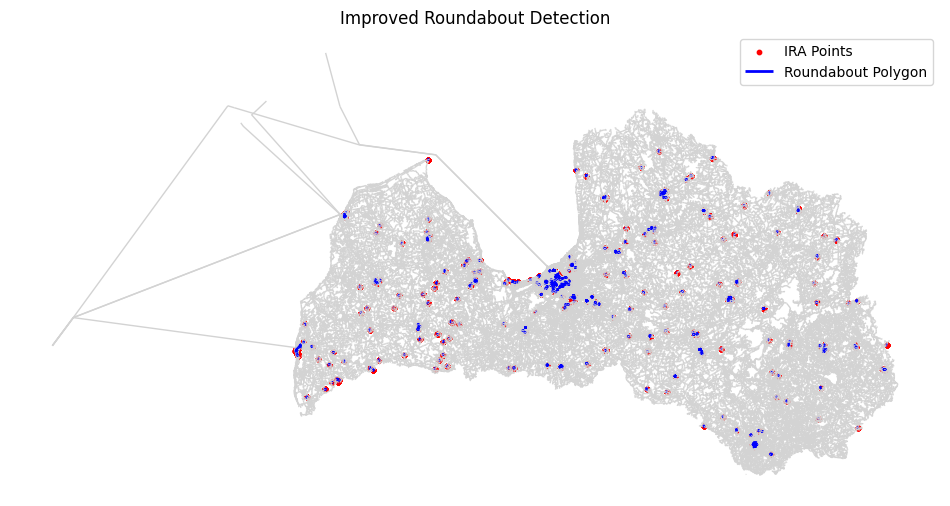

In [3]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString, MultiPoint
import networkx as nx
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os
import zipfile
import shutil

# === Load and Preprocess ===
streets = gpd.read_file("Streets.shp").to_crs(epsg=3857)

# Optional: Filter common road types (if 'type' column exists)
if 'type' in streets.columns:
    streets = streets[streets['type'].isin(['primary', 'secondary', 'tertiary', 'residential'])]

# === Step 1: Extract Points from LineStrings ===
all_points = []
for _, row in streets.iterrows():
    geom = row.geometry
    lines = [geom] if geom.geom_type == 'LineString' else list(geom)
    for line in lines:
        all_points.extend([Point(pt) for pt in line.coords])

points_gdf = gpd.GeoDataFrame(geometry=all_points, crs=streets.crs)
coords = np.array([[pt.x, pt.y] for pt in points_gdf.geometry])

# === Step 2: Graph Construction (increased r slightly) ===
tree = KDTree(coords)
G = nx.Graph()
for i, point in enumerate(coords):
    for j in tree.query_ball_point(point, r=27):  # connectivity range
        if i != j:
            dist = np.linalg.norm(coords[i] - coords[j])
            G.add_edge(i, j, weight=dist)

# === Step 3: Circularity Check Helper ===
def is_circular_cycle(cycle_nodes, coords, min_circularity=0.65, max_radius_std=17, min_diameter=17, max_diameter=270):
    cycle_coords = coords[cycle_nodes]
    multipoint = MultiPoint([Point(p) for p in cycle_coords])
    try:
        hull = multipoint.convex_hull
        area = hull.area
        perimeter = hull.length
    except:
        return False
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    center = np.mean(cycle_coords, axis=0)
    radii = np.linalg.norm(cycle_coords - center, axis=1)
    radius_std = np.std(radii)
    diameter = np.max(radii) * 2
    return (min_diameter <= diameter <= max_diameter and
            circularity >= min_circularity and
            radius_std <= max_radius_std)

# === Step 4: Detect Cycles & Validate ===
IRA_flags = [False] * len(points_gdf)
roundabout_polygons = []

for cycle in nx.cycle_basis(G):
    if len(cycle) < 6:
        continue
    cycle_coords = coords[cycle]
    avg_edge_len = np.mean([
        np.linalg.norm(coords[i] - coords[j])
        for i in cycle for j in G.neighbors(i) if j in cycle
    ])
    if is_circular_cycle(cycle, coords) and avg_edge_len < 50:
        exit_count = sum(len(set(G.neighbors(node)) - set(cycle)) > 0 for node in cycle)
        if exit_count >= 3:
            for node in cycle:
                IRA_flags[node] = True
            poly = MultiPoint([Point(p) for p in coords[cycle]]).convex_hull
            roundabout_polygons.append(poly)

# === Step 5: Save Output ===
output_folder = "Roundabout_Output"
os.makedirs(output_folder, exist_ok=True)

points_gdf["IRA"] = IRA_flags
points_gdf.to_file(f"{output_folder}/Streets_points_IRA.shp")

roundabouts_gdf = gpd.GeoDataFrame(geometry=roundabout_polygons, crs=streets.crs)
roundabouts_gdf.to_file(f"{output_folder}/Detected_Roundabouts.shp")

shutil.make_archive("Roundabout_Detection_Results", 'zip', output_folder)

# === Step 6: Visualize ===
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, color='lightgray', linewidth=1)
points_gdf[points_gdf["IRA"]].plot(ax=ax, color='red', markersize=10, label='IRA Points')
roundabouts_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='Roundabout Polygon')
plt.legend()
plt.title("Improved Roundabout Detection")
plt.axis("off")
plt.show()


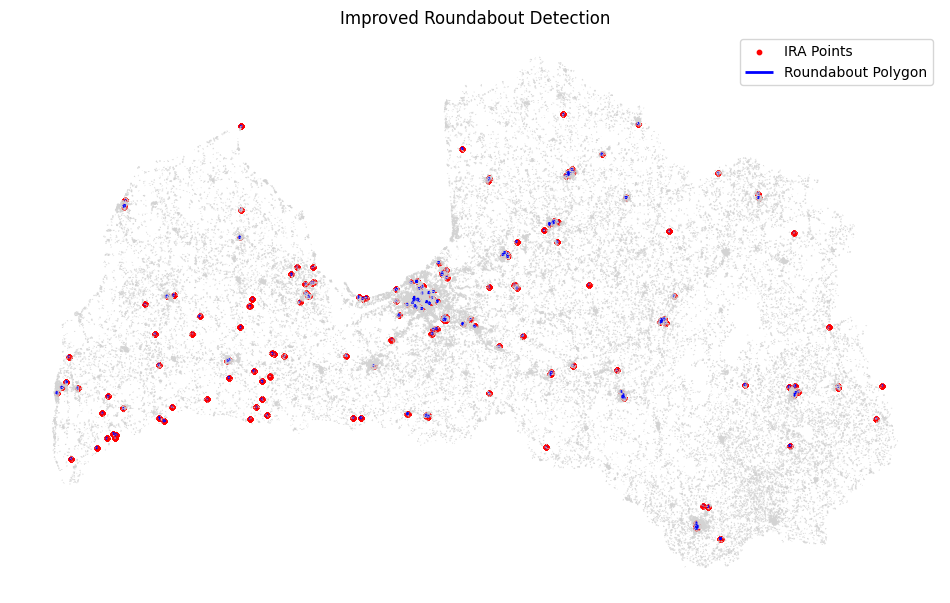

In [5]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString, MultiPoint
import networkx as nx
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os
import zipfile
import shutil

# === Load and Preprocess ===
streets = gpd.read_file("filtered_roundabout_candidates_bestonly_1lakh_soGoog_gappy.shp").to_crs(epsg=3857)

# Optional: Filter common road types (if 'type' column exists)
if 'type' in streets.columns:
    streets = streets[streets['type'].isin(['primary', 'secondary', 'tertiary', 'residential'])]

# === Step 1: Extract Points from LineStrings ===
all_points = []
for _, row in streets.iterrows():
    geom = row.geometry
    lines = [geom] if geom.geom_type == 'LineString' else list(geom)
    for line in lines:
        all_points.extend([Point(pt) for pt in line.coords])

points_gdf = gpd.GeoDataFrame(geometry=all_points, crs=streets.crs)
coords = np.array([[pt.x, pt.y] for pt in points_gdf.geometry])

# === Step 2: Graph Construction (increased r slightly) ===
tree = KDTree(coords)
G = nx.Graph()
for i, point in enumerate(coords):
    for j in tree.query_ball_point(point, r=27):  # connectivity range
        if i != j:
            dist = np.linalg.norm(coords[i] - coords[j])
            G.add_edge(i, j, weight=dist)

# === Step 3: Circularity Check Helper ===
def is_circular_cycle(cycle_nodes, coords, min_circularity=0.75, max_radius_std=9, min_diameter=31, max_diameter=350):
    cycle_coords = coords[cycle_nodes]
    multipoint = MultiPoint([Point(p) for p in cycle_coords])
    try:
        hull = multipoint.convex_hull
        area = hull.area
        perimeter = hull.length
    except:
        return False
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    center = np.mean(cycle_coords, axis=0)
    radii = np.linalg.norm(cycle_coords - center, axis=1)
    radius_std = np.std(radii)
    diameter = np.max(radii) * 2
    return (min_diameter <= diameter <= max_diameter and
            circularity >= min_circularity and
            radius_std <= max_radius_std)

# === Step 4: Detect Cycles & Validate ===
IRA_flags = [False] * len(points_gdf)
roundabout_polygons = []

for cycle in nx.cycle_basis(G):
    if len(cycle) < 7:
        continue
    cycle_coords = coords[cycle]
    avg_edge_len = np.mean([
        np.linalg.norm(coords[i] - coords[j])
        for i in cycle for j in G.neighbors(i) if j in cycle
    ])
    if is_circular_cycle(cycle, coords) and avg_edge_len < 50:
        exit_count = sum(len(set(G.neighbors(node)) - set(cycle)) > 0 for node in cycle)
        if exit_count >= 3:
            for node in cycle:
                IRA_flags[node] = True
            poly = MultiPoint([Point(p) for p in coords[cycle]]).convex_hull
            roundabout_polygons.append(poly)

# === Step 5: Save Output ===
output_folder = "Best_Roundabout_Output"
os.makedirs(output_folder, exist_ok=True)

points_gdf["IRA"] = IRA_flags
points_gdf.to_file(f"{output_folder}/Streets_points_IRA.shp")

roundabouts_gdf = gpd.GeoDataFrame(geometry=roundabout_polygons, crs=streets.crs)
roundabouts_gdf.to_file(f"{output_folder}/Detected_Roundabouts.shp")

shutil.make_archive("Best_Roundabout_Detection_Results", 'zip', output_folder)

# === Step 6: Visualize ===
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, color='lightgray', linewidth=1)
points_gdf[points_gdf["IRA"]].plot(ax=ax, color='red', markersize=10, label='IRA Points')
roundabouts_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='Roundabout Polygon')
plt.legend()
plt.title("Improved Roundabout Detection")
plt.axis("off")
plt.show()


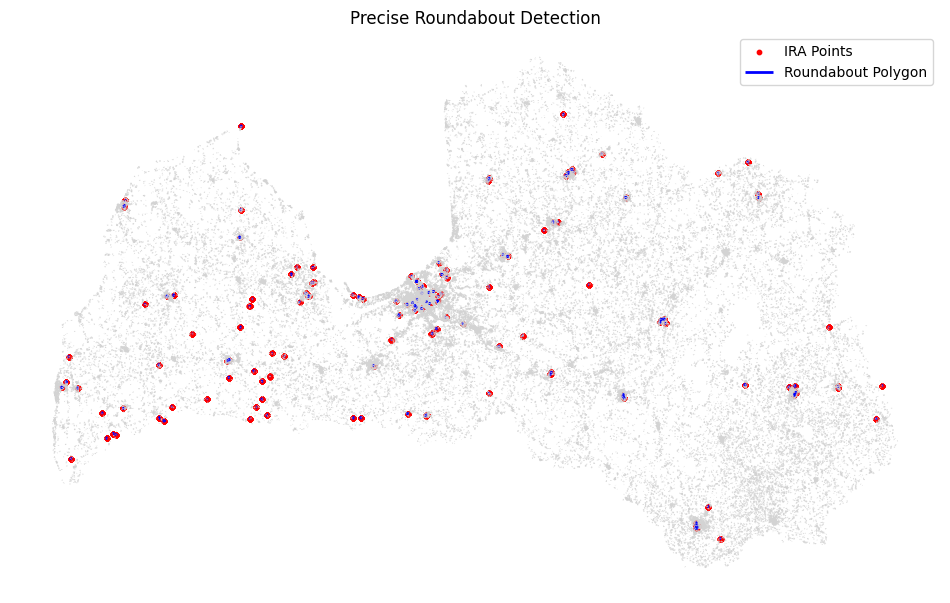

In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString, MultiPoint
import networkx as nx
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os
import shutil

# === Load and Preprocess ===
streets = gpd.read_file("filtered_roundabout_candidates_bestonly_1lakh_soGoog_gappy.shp").to_crs(epsg=3857)

# Optional: Filter common road types (if 'type' column exists)
if 'type' in streets.columns:
    streets = streets[streets['type'].isin(['primary', 'secondary', 'tertiary', 'residential'])]

# === Step 1: Extract Points from LineStrings ===
all_points = []
for _, row in streets.iterrows():
    geom = row.geometry
    lines = [geom] if geom.geom_type == 'LineString' else list(geom)
    for line in lines:
        all_points.extend([Point(pt) for pt in line.coords])

points_gdf = gpd.GeoDataFrame(geometry=all_points, crs=streets.crs)
coords = np.array([[pt.x, pt.y] for pt in points_gdf.geometry])

# === Step 2: Graph Construction (slightly tuned connectivity) ===
tree = KDTree(coords)
G = nx.Graph()
for i, point in enumerate(coords):
    for j in tree.query_ball_point(point, r=28):  # precise connectivity range
        if i != j:
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist < 45:
                G.add_edge(i, j, weight=dist)

# === Step 3: Circularity Check Helper ===
def is_circular_cycle(cycle_nodes, coords, min_circularity=0.78, max_radius_std=7, min_diameter=20, max_diameter=90):
    cycle_coords = coords[cycle_nodes]
    multipoint = MultiPoint([Point(p) for p in cycle_coords])
    try:
        hull = multipoint.convex_hull
        area = hull.area
        perimeter = hull.length
    except:
        return False
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    center = np.mean(cycle_coords, axis=0)
    radii = np.linalg.norm(cycle_coords - center, axis=1)
    radius_std = np.std(radii)
    diameter = np.max(radii) * 2
    return (min_diameter <= diameter <= max_diameter and
            circularity >= min_circularity and
            radius_std <= max_radius_std)

# === Step 4: Detect Cycles & Validate ===
IRA_flags = [False] * len(points_gdf)
roundabout_polygons = []

for cycle in nx.cycle_basis(G):
    if len(cycle) < 8 or len(cycle) > 60:
        continue
    cycle_coords = coords[cycle]
    avg_edge_len = np.mean([
        np.linalg.norm(coords[i] - coords[j])
        for i in cycle for j in G.neighbors(i) if j in cycle
    ])
    if avg_edge_len > 35:
        continue
    if is_circular_cycle(cycle, coords):
        exit_count = sum(len(set(G.neighbors(node)) - set(cycle)) > 0 for node in cycle)
        if exit_count >= 3:
            for node in cycle:
                IRA_flags[node] = True
            poly = MultiPoint([Point(p) for p in coords[cycle]]).convex_hull
            roundabout_polygons.append(poly)

# === Step 5: Save Output ===
output_folder = "Precise_Roundabout_Output"
os.makedirs(output_folder, exist_ok=True)

points_gdf["IRA"] = IRA_flags
points_gdf.to_file(f"{output_folder}/Streets_points_IRA.shp")

roundabouts_gdf = gpd.GeoDataFrame(geometry=roundabout_polygons, crs=streets.crs)
roundabouts_gdf.to_file(f"{output_folder}/Detected_Roundabouts.shp")

shutil.make_archive("Precise_Roundabout_Detection_Results", 'zip', output_folder)

# === Step 6: Visualize ===
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, color='lightgray', linewidth=1)
points_gdf[points_gdf["IRA"]].plot(ax=ax, color='red', markersize=10, label='IRA Points')
roundabouts_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='Roundabout Polygon')
plt.legend()
plt.title("Precise Roundabout Detection")
plt.axis("off")
plt.show()


Total cycles analyzed: 122337
Roundabouts detected: 143
Sample stats of detections:
  #1: Nodes=13, AvgEdge=23.18, Exits=10
  #2: Nodes=13, AvgEdge=23.09, Exits=10
  #3: Nodes=13, AvgEdge=23.18, Exits=10
  #4: Nodes=12, AvgEdge=25.61, Exits=12
  #5: Nodes=12, AvgEdge=25.61, Exits=12


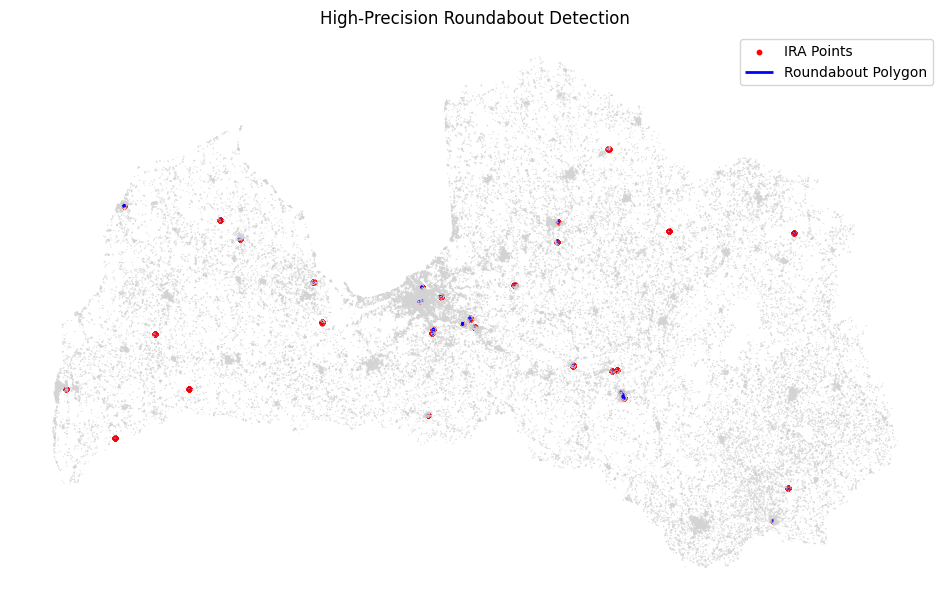

In [5]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString, MultiPoint
import networkx as nx
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os
import shutil

# === Load and Preprocess ===
streets = gpd.read_file("filtered_roundabout_candidates_bestonly_1lakh_soGoog_gappy.shp").to_crs(epsg=3857)

# Optional: Filter common road types (if applicable)
if 'type' in streets.columns:
    streets = streets[streets['type'].isin(['primary', 'secondary', 'tertiary', 'residential'])]

# === Extract Points ===
all_points = []
for _, row in streets.iterrows():
    geom = row.geometry
    lines = [geom] if geom.geom_type == 'LineString' else list(geom)
    for line in lines:
        all_points.extend([Point(pt) for pt in line.coords])

points_gdf = gpd.GeoDataFrame(geometry=all_points, crs=streets.crs)
coords = np.array([[pt.x, pt.y] for pt in points_gdf.geometry])

# === Graph Construction (relaxed) ===
tree = KDTree(coords)
G = nx.Graph()
for i, pt in enumerate(coords):
    for j in tree.query_ball_point(pt, r=35):  # Increase connectivity range
        if i != j:
            G.add_edge(i, j)

# === Roundness Check ===
def is_roundabout(cycle, coords):
    cycle_coords = coords[cycle]
    mp = MultiPoint([Point(p) for p in cycle_coords])
    if len(cycle_coords) < 4:
        return False

    hull = mp.convex_hull
    if hull.geom_type != 'Polygon':
        return False

    area = hull.area
    perimeter = hull.length
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    center = np.mean(cycle_coords, axis=0)
    radii = np.linalg.norm(cycle_coords - center, axis=1)
    radius_std = np.std(radii)
    diameter = np.max(radii) * 2

    min_diameter, max_diameter = 20, 360  # meters
    if not (min_diameter <= diameter <= max_diameter):
        return False
    if circularity < 0.85:
        return False
    if radius_std > 10:
        return False

    # Bounding box ratio check
    bounds = hull.bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    if max(width, height) / min(width, height) > 2:
        return False

    return True

# === Detect Roundabouts ===
IRA_flags = [False] * len(points_gdf)
roundabout_polygons = []
stats = []

for cycle in nx.cycle_basis(G):
    if len(cycle) < 11:
        continue

    cycle_coords = coords[cycle]
    avg_edge_len = np.mean([
        np.linalg.norm(coords[i] - coords[j])
        for i in cycle for j in G.neighbors(i) if j in cycle
    ])
    exit_count = sum(len(set(G.neighbors(node)) - set(cycle)) > 0 for node in cycle)

    if exit_count > 3 and avg_edge_len < 100 and is_roundabout(cycle, coords):
        for node in cycle:
            IRA_flags[node] = True
        poly = MultiPoint([Point(p) for p in coords[cycle]]).convex_hull
        roundabout_polygons.append(poly)

        # Debug info
        stats.append({
            "cycle_size": len(cycle),
            "edge_len": round(avg_edge_len, 2),
            "exit_count": exit_count,
        })

print(f"Total cycles analyzed: {len(nx.cycle_basis(G))}")
print(f"Roundabouts detected: {len(roundabout_polygons)}")
print("Sample stats of detections:")
for i, stat in enumerate(stats[:5]):
    print(f"  #{i+1}: Nodes={stat['cycle_size']}, AvgEdge={stat['edge_len']}, Exits={stat['exit_count']}")

# === Save Output ===
output_folder = "Accurate_Roundabout_Output"
os.makedirs(output_folder, exist_ok=True)

points_gdf["IRA"] = IRA_flags
points_gdf.to_file(f"{output_folder}/Streets_points_IRA.shp")

roundabouts_gdf = gpd.GeoDataFrame(geometry=roundabout_polygons, crs=streets.crs)
roundabouts_gdf.to_file(f"{output_folder}/Detected_Roundabouts.shp")

shutil.make_archive("Accurate_Roundabout_Results", 'zip', output_folder)

# === Visualization ===
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, color='lightgray', linewidth=1)
points_gdf[points_gdf["IRA"]].plot(ax=ax, color='red', markersize=10, label='IRA Points')
roundabouts_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='Roundabout Polygon')
plt.legend()
plt.title("High-Precision Roundabout Detection")
plt.axis("off")
plt.show()
